In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import yfinance as yf
import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import coint
from sklearn.model_selection import train_test_split


In [ ]:
companies=pd.DataFrame()
stocks=["AAPL", "MSFT", "GOOGL", "AMZN", "TSLA", "JPM", "WMT", "JNJ", "V", "PG", "KO", "NFLX", "DIS", "NVDA", "VZ", "T", "IBM", "HD","BA","MA"]
for stock in stocks:
    stk=yf.Ticker(stock)
    data=stk.history(start='2017-06-01',end='2023-07-31')
    companies[stock]=data['Close']
companies.head()


,AAPL,MSFT,GOOGL,AMZN,TSLA,JPM,WMT,JNJ,V,PG,KO,NFLX,DIS,NVDA,VZ,T,IBM,HD,BA,MA
Date,,,,,,,,,,,,,,,,,,,,
2017-06-01 00:00:00-04:00,35.680157,64.035118,49.119915,49.797501,22.691334,66.622414,23.239697,103.118607,90.287674,71.196579,35.344952,162.990005,102.359573,3.563799,30.495092,16.202534,102.094559,127.895836,176.507355,117.928375
2017-06-02 00:00:00-04:00,36.208908,65.551529,49.509079,50.336498,22.656668,66.285530,23.184368,104.159584,90.997459,71.568192,35.422131,165.179993,101.385269,3.546025,30.449190,16.202534,101.679932,128.060684,179.249359,119.648544
2017-06-05 00:00:00-04:00,35.854843,66.026482,49.894764,50.567001,23.154667,66.405846,23.370729,104.383789,91.376015,71.689377,35.499321,165.059998,100.760948,3.653905,30.403294,16.177525,101.920700,127.599022,178.043243,120.317513
2017-06-06 00:00:00-04:00,35.975986,66.245735,49.536907,50.150002,23.523333,66.542206,22.983450,104.760147,90.656776,71.737831,35.491608,165.169998,99.796082,3.637366,30.449190,16.144182,101.893944,127.112679,175.970261,119.686760
2017-06-07 00:00:00-04:00,36.190273,66.126991,49.776474,50.503502,23.976667,67.304184,23.047510,104.696068,90.940666,71.713593,35.128819,165.610001,100.193375,3.681308,30.488529,16.156681,100.964378,127.739166,177.242340,119.638977


Text(0.5, 1.0, 'Assets Correlation Matrix')

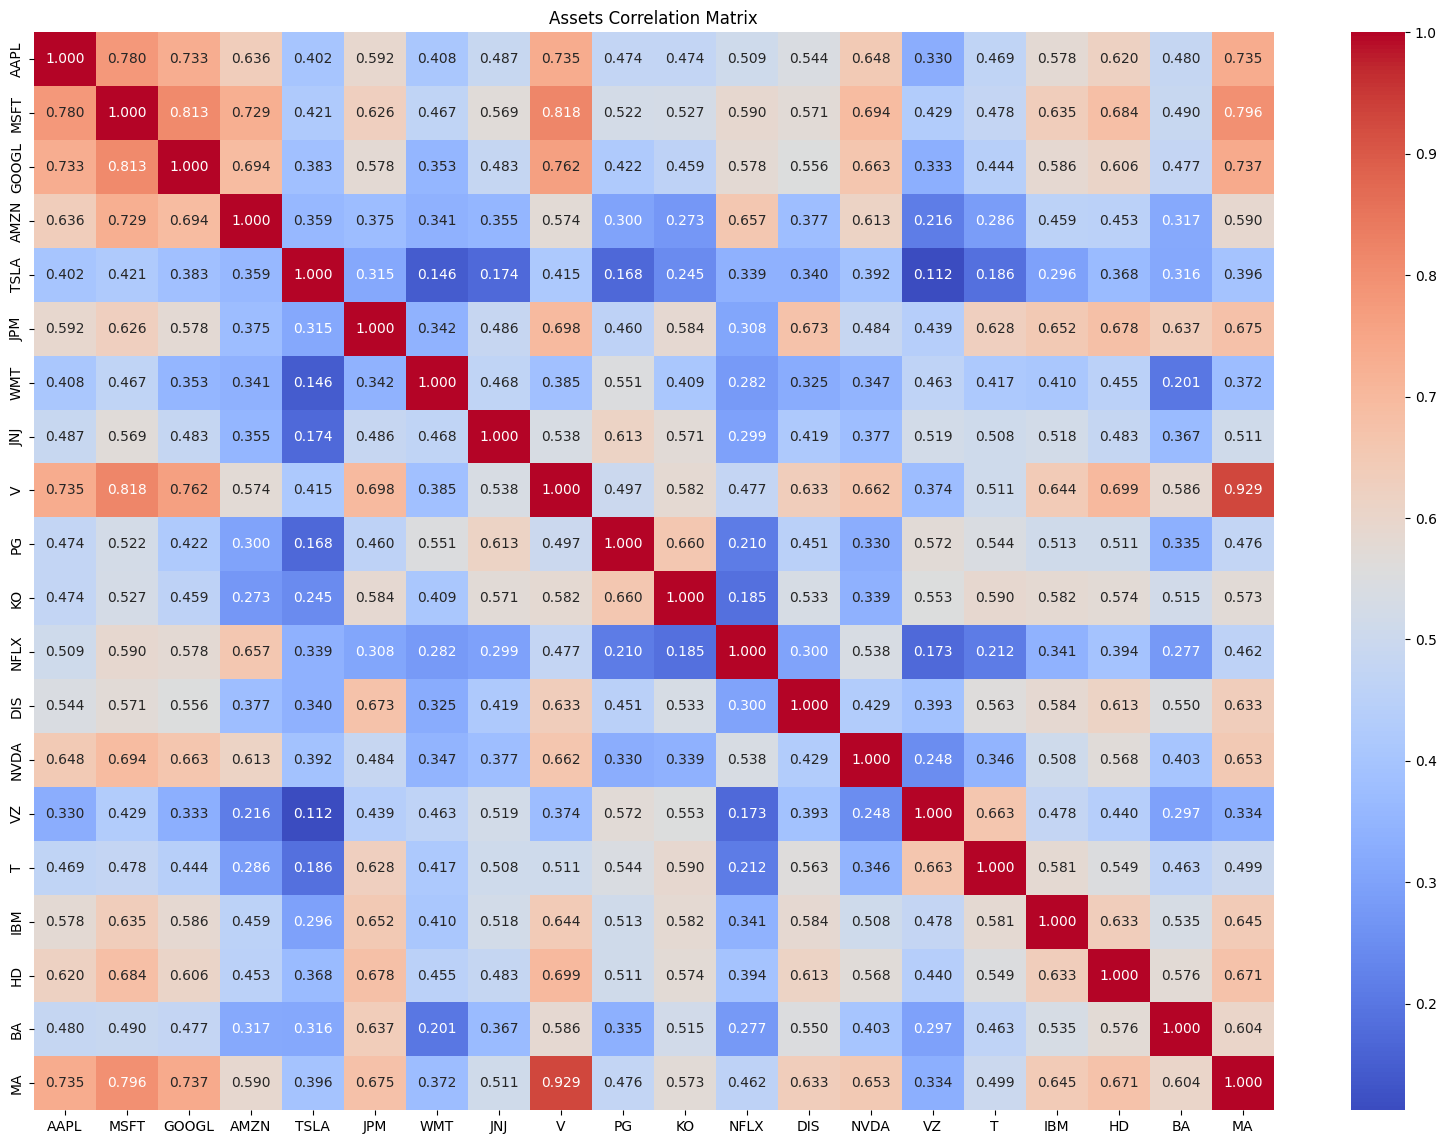

In [ ]:
train_close, test_close = train_test_split(companies, test_size=0.5, shuffle=False)
fig, ax = plt.subplots(figsize=(20,14))
sns.heatmap(train_close.pct_change().corr(method ='pearson'), ax=ax, cmap='coolwarm', annot=True, fmt=".3f") #spearman
ax.set_title('Assets Correlation Matrix')

In [ ]:
def find_cointegrated_pairs(data):
    n = data.shape[1]
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            result = coint(data[keys[i]], data[keys[j]])
            pvalue_matrix[i, j] = result[1]
            if result[1] < 0.05:
                pairs.append((keys[i], keys[j]))
    return pvalue_matrix, pairs
pvalues, pairs = find_cointegrated_pairs(train_close)
print(pairs)


[('GOOGL', 'HD'), ('JNJ', 'V'), ('JNJ', 'PG'), ('JNJ', 'VZ'), ('JNJ', 'MA'), ('V', 'MA'), ('KO', 'DIS'), ('IBM', 'HD'), ('IBM', 'BA'), ('IBM', 'MA'), ('HD', 'MA')]


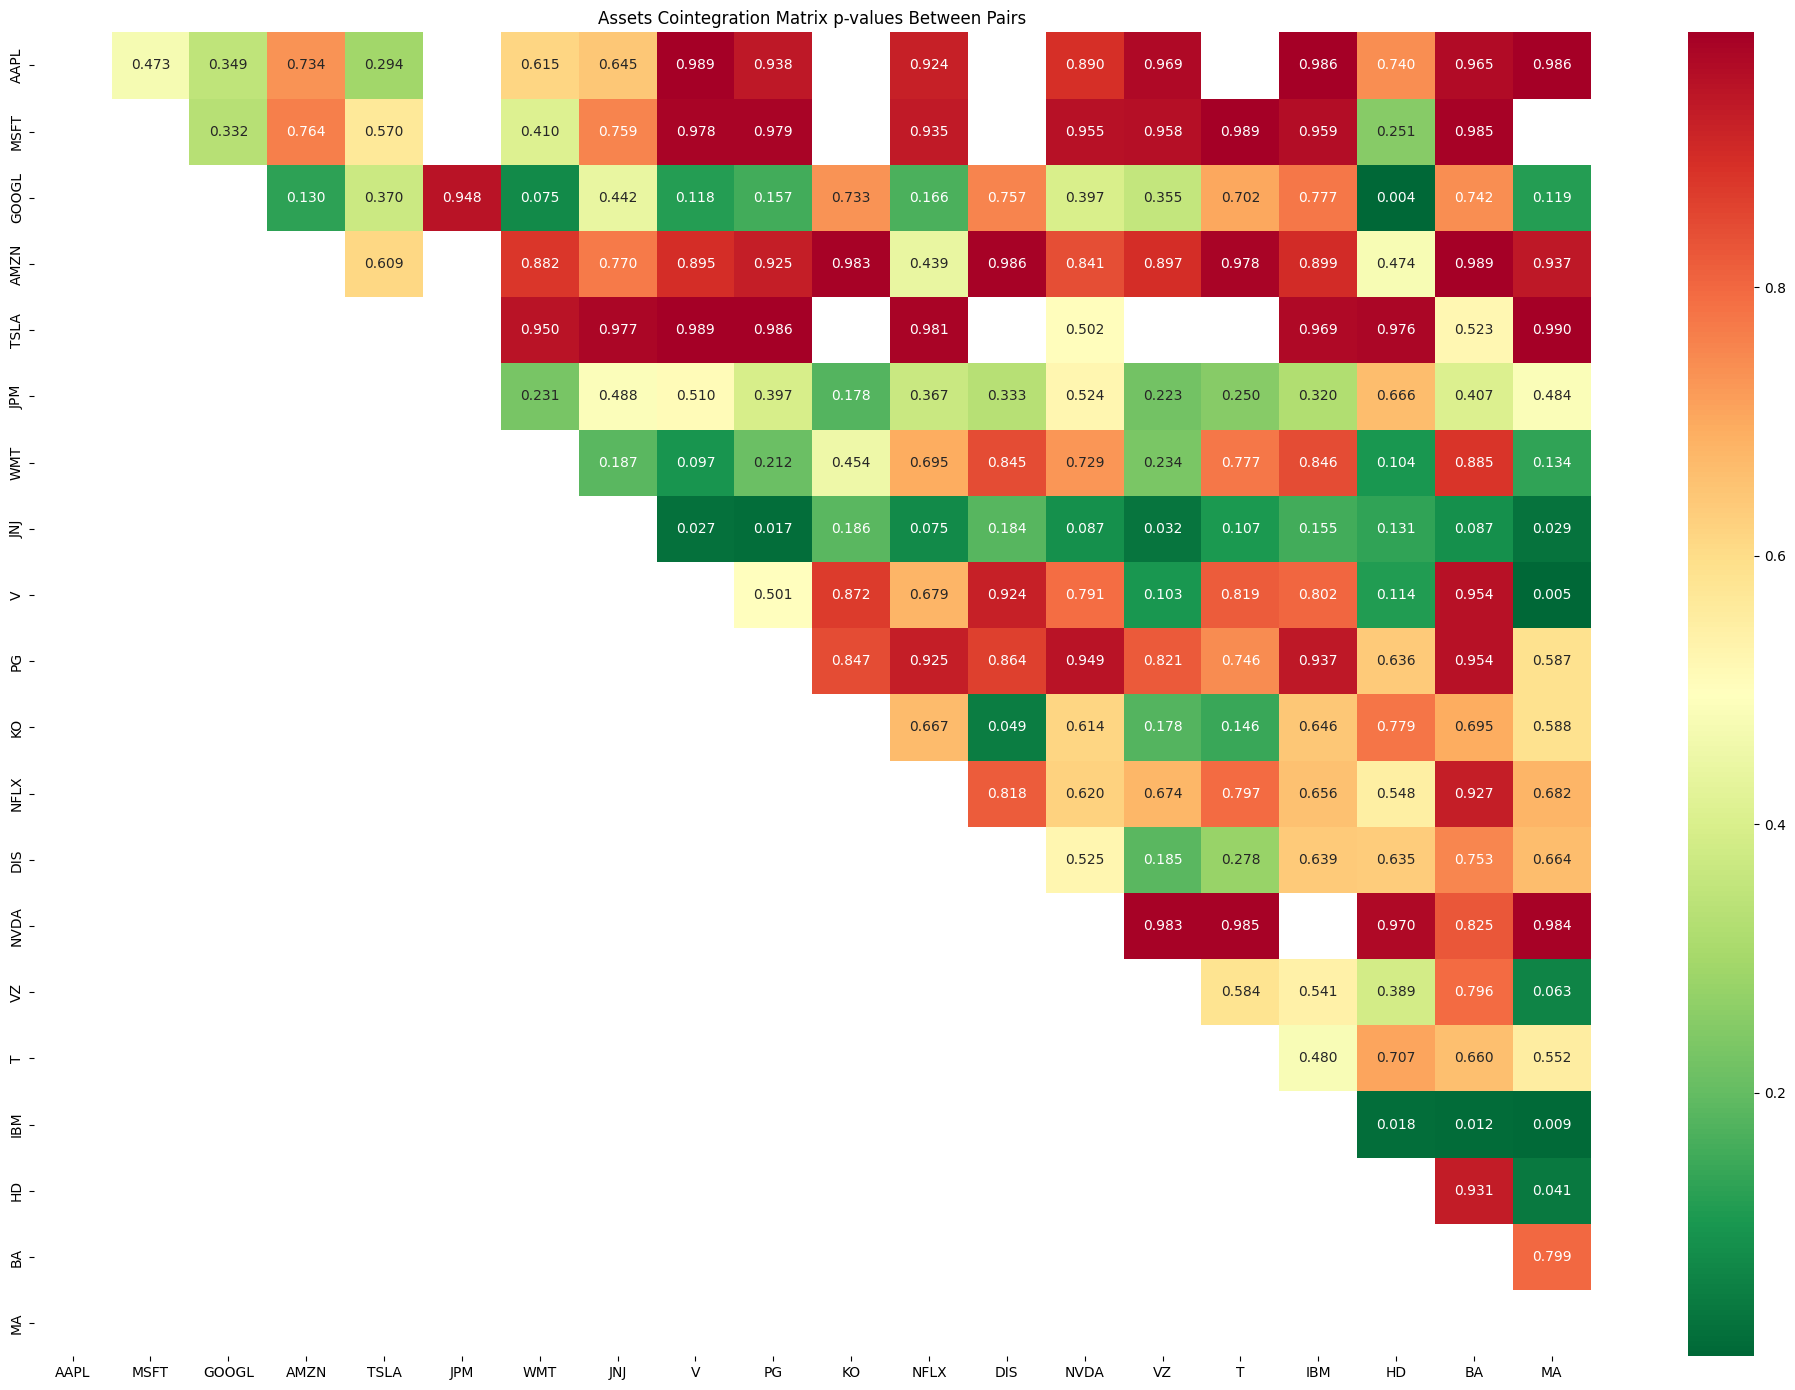

In [ ]:
fig, ax = plt.subplots(figsize=(20,14))
sns.heatmap(pvalues, xticklabels = train_close.columns,
                yticklabels = train_close.columns, cmap = 'RdYlGn_r', annot = True, fmt=".3f",
                mask = (pvalues >= 0.99))
ax.set_title('Assets Cointegration Matrix p-values Between Pairs')
plt.tight_layout()

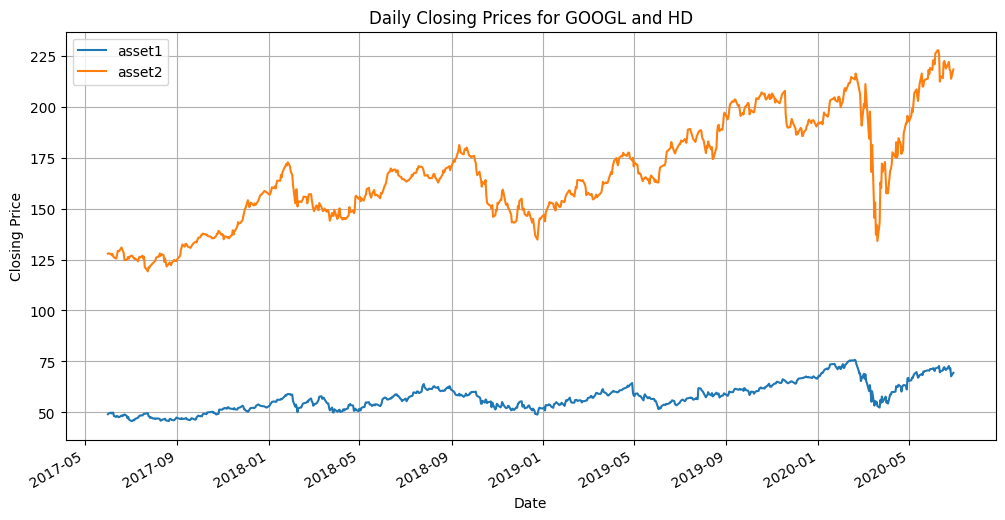

In [ ]:
asset1,asset2='GOOGL','HD'
train = pd.DataFrame()
train['asset1'] = train_close[asset1]
train['asset2'] = train_close[asset2]
ax = train[['asset1','asset2']].plot(figsize=(12,6), title = 'Daily Closing Prices for {} and {}'.format(asset1,asset2))
ax.set_ylabel("Closing Price")
ax.grid(True)

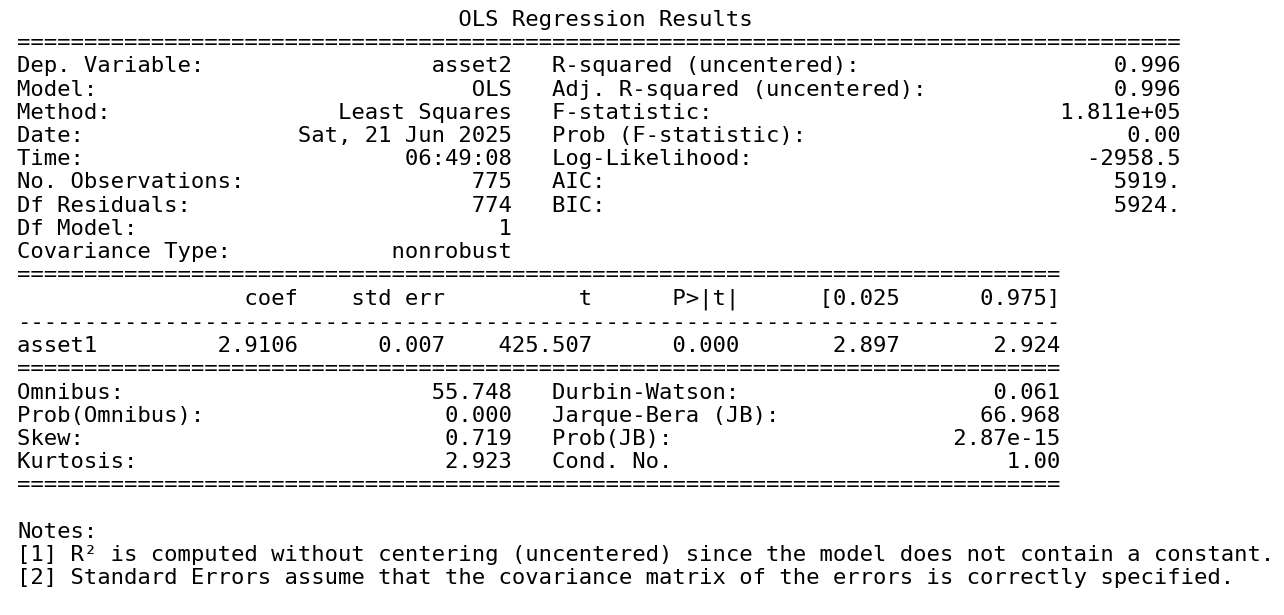

In [ ]:
model=sm.OLS(train.asset2, train.asset1).fit()
plt.rc('figure', figsize=(12, 7))
plt.text(0.01, 0.05, str(model.summary()), {'fontsize': 16}, fontproperties = 'monospace')
plt.axis('off')
plt.tight_layout()
plt.subplots_adjust(left=0.2, right=0.8, top=0.7, bottom=0.1)

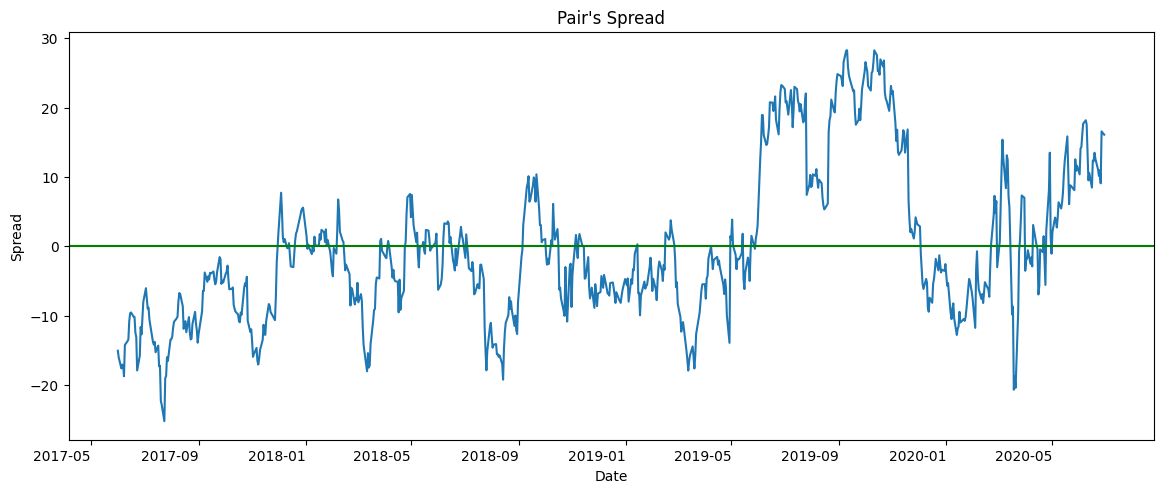

In [ ]:
spread = train.asset2 - model.params[0] * train.asset1
ax = spread.plot(figsize=(14, 6), title = "Pair's Spread",rot=0)
ax.set_ylabel("Spread")
ax.axhline(0,c='g')

In [ ]:
adf = adfuller(spread, maxlag = 1)
print('T- Statistic = ', adf[0])
print("Critical Values",adf[4])

T- Statistic =  -3.439627196077755
Critical Values {'1%': np.float64(-3.4388268991356936), '5%': np.float64(-2.8652813916285518), '10%': np.float64(-2.5687622857867782)}


In [ ]:
win=10
test=pd.concat([train_close[train_close.shape[0]-win-1:],test_close], sort=False)
signs = pd.DataFrame()
signs['asset1'] = test[asset1]
signs['asset2'] = test[asset2]
ratios = signs.asset1 / signs.asset2
ratios_mavg5 = ratios.rolling(window=6, center=False).mean()
ratios_mavg5=ratios_mavg5[win:]
ratios_mavg10 = ratios.rolling(window=win, center=False).mean()
ratios_mavg10=ratios_mavg10[win:]
std_10 = ratios.rolling(window=win, center=False).std()
std_10=std_10[win:]
zscore_10_5 = (ratios_mavg5 - ratios_mavg10)/std_10
ratios=ratios[win:]
zscore_10_5=zscore_10_5.dropna()

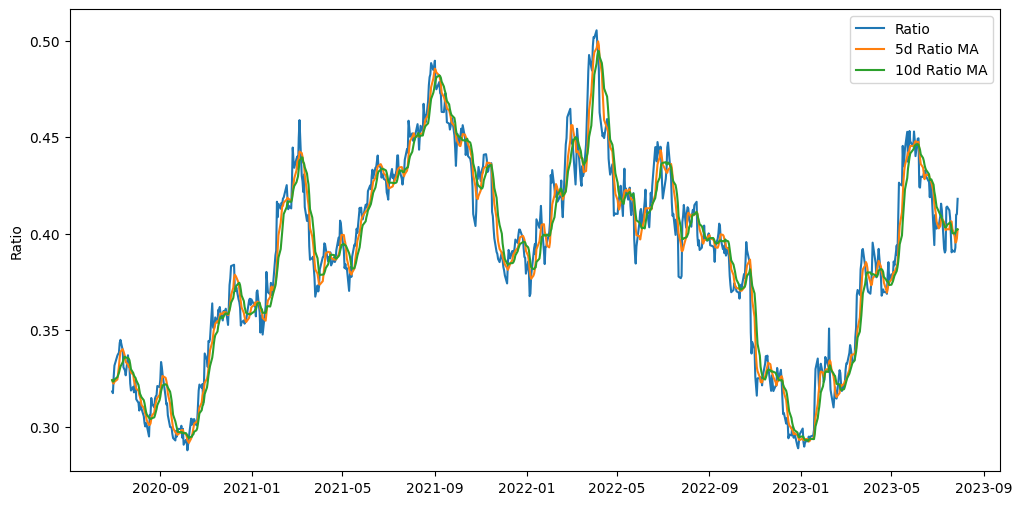

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(ratios.index, ratios.values)
plt.plot(ratios_mavg5.index, ratios_mavg5.values)
plt.plot(ratios_mavg10.index, ratios_mavg10.values)
plt.legend(['Ratio', '5d Ratio MA', '10d Ratio MA'])
plt.ylabel('Ratio')
plt.show()



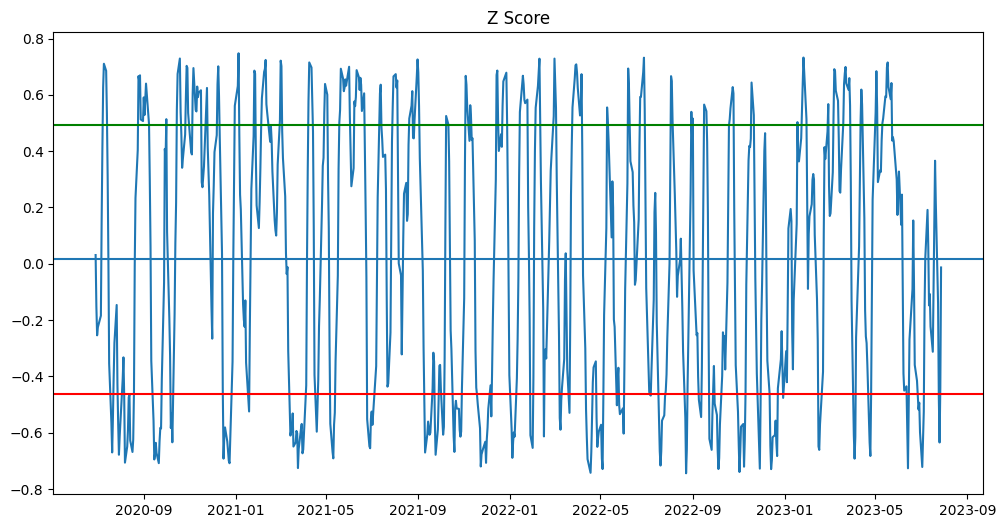

In [ ]:
plt.figure(figsize=(12, 6))
plt.title("Z Score")
plt.plot(zscore_10_5)
plt.axhline(zscore_10_5.mean())
plt.axhline(zscore_10_5.std()+zscore_10_5.mean(), c='g')
plt.axhline(zscore_10_5.mean()-zscore_10_5.std(),c='r')



In [ ]:
signals = pd.DataFrame()
signals['asset1'] = test_close[asset1]
signals['asset2'] = test_close[asset2]
ratios = signals.asset1 / signals.asset2
signals['z'] = zscore_10_5
signals['z upper limit'] = np.mean(signals['z']) + np.std(signals['z'])
signals['z lower limit'] = np.mean(signals['z']) - np.std(signals['z'])
signals['signals1'] = 0
signals['signals1'] = np.select([signals['z'] > signals['z upper limit'], signals['z'] < signals['z lower limit']], [-1, 1], default=0)
signals['positions1'] = signals['signals1'].diff()
signals['signals2'] = -signals['signals1']
signals['positions2'] = signals['signals2'].diff()
signals=signals.dropna()



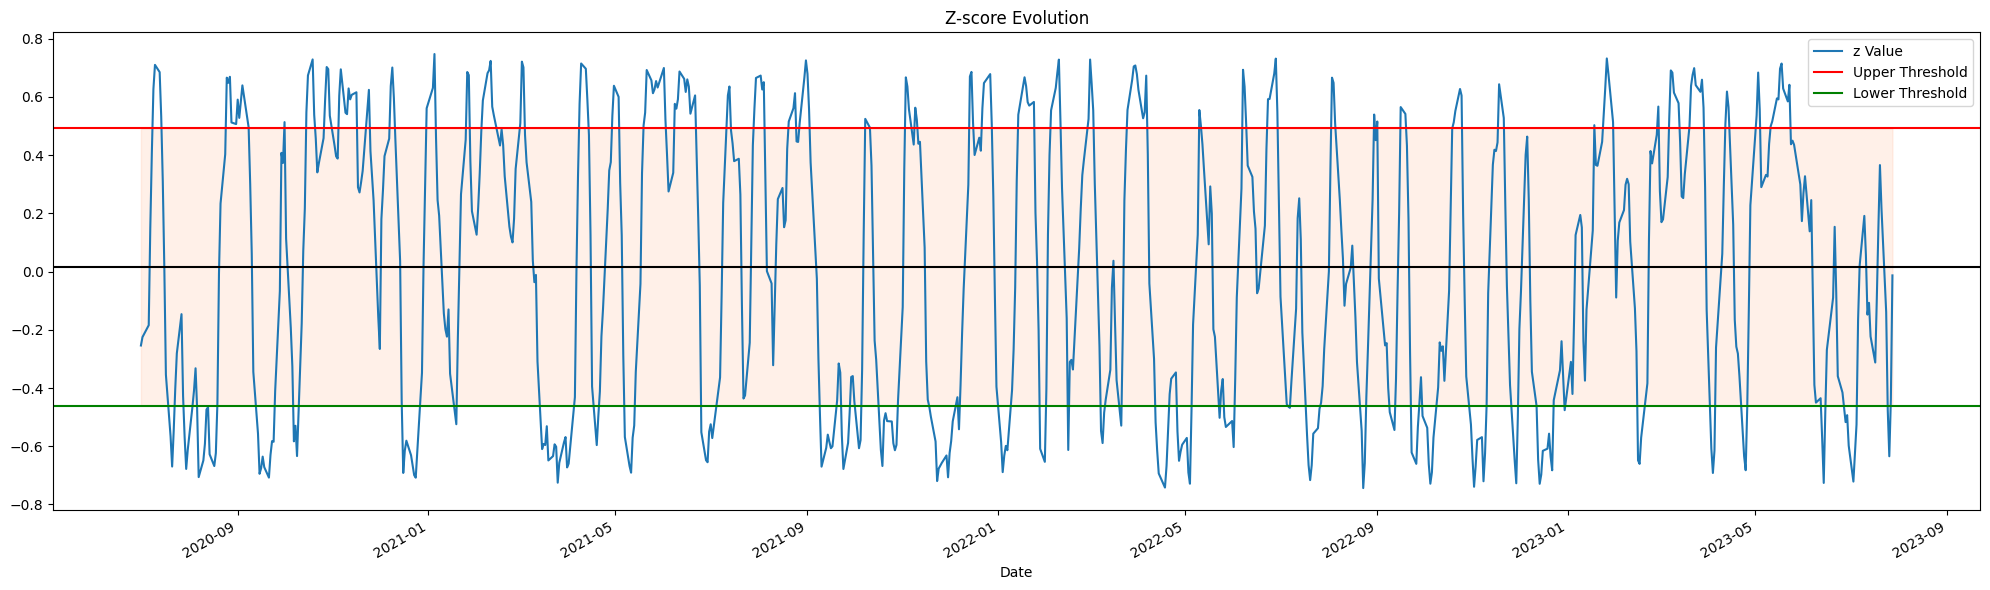

In [ ]:
plt.figure(figsize=(20,6))
signals['z'].plot(label="z Value")
plt.title("Z-score Evolution")
plt.axhline(signals['z'].mean(),color="black")
plt.axhline(signals['z upper limit'].mean(), color="red", label="Upper Threshold")
plt.axhline(signals['z lower limit'].mean(), color="green", label="Lower Threshold")
plt.fill_between(signals.index,signals['z upper limit'],\
            signals['z lower limit'], \
            alpha=0.2,color='#ffb48f')
plt.legend()
plt.tight_layout()

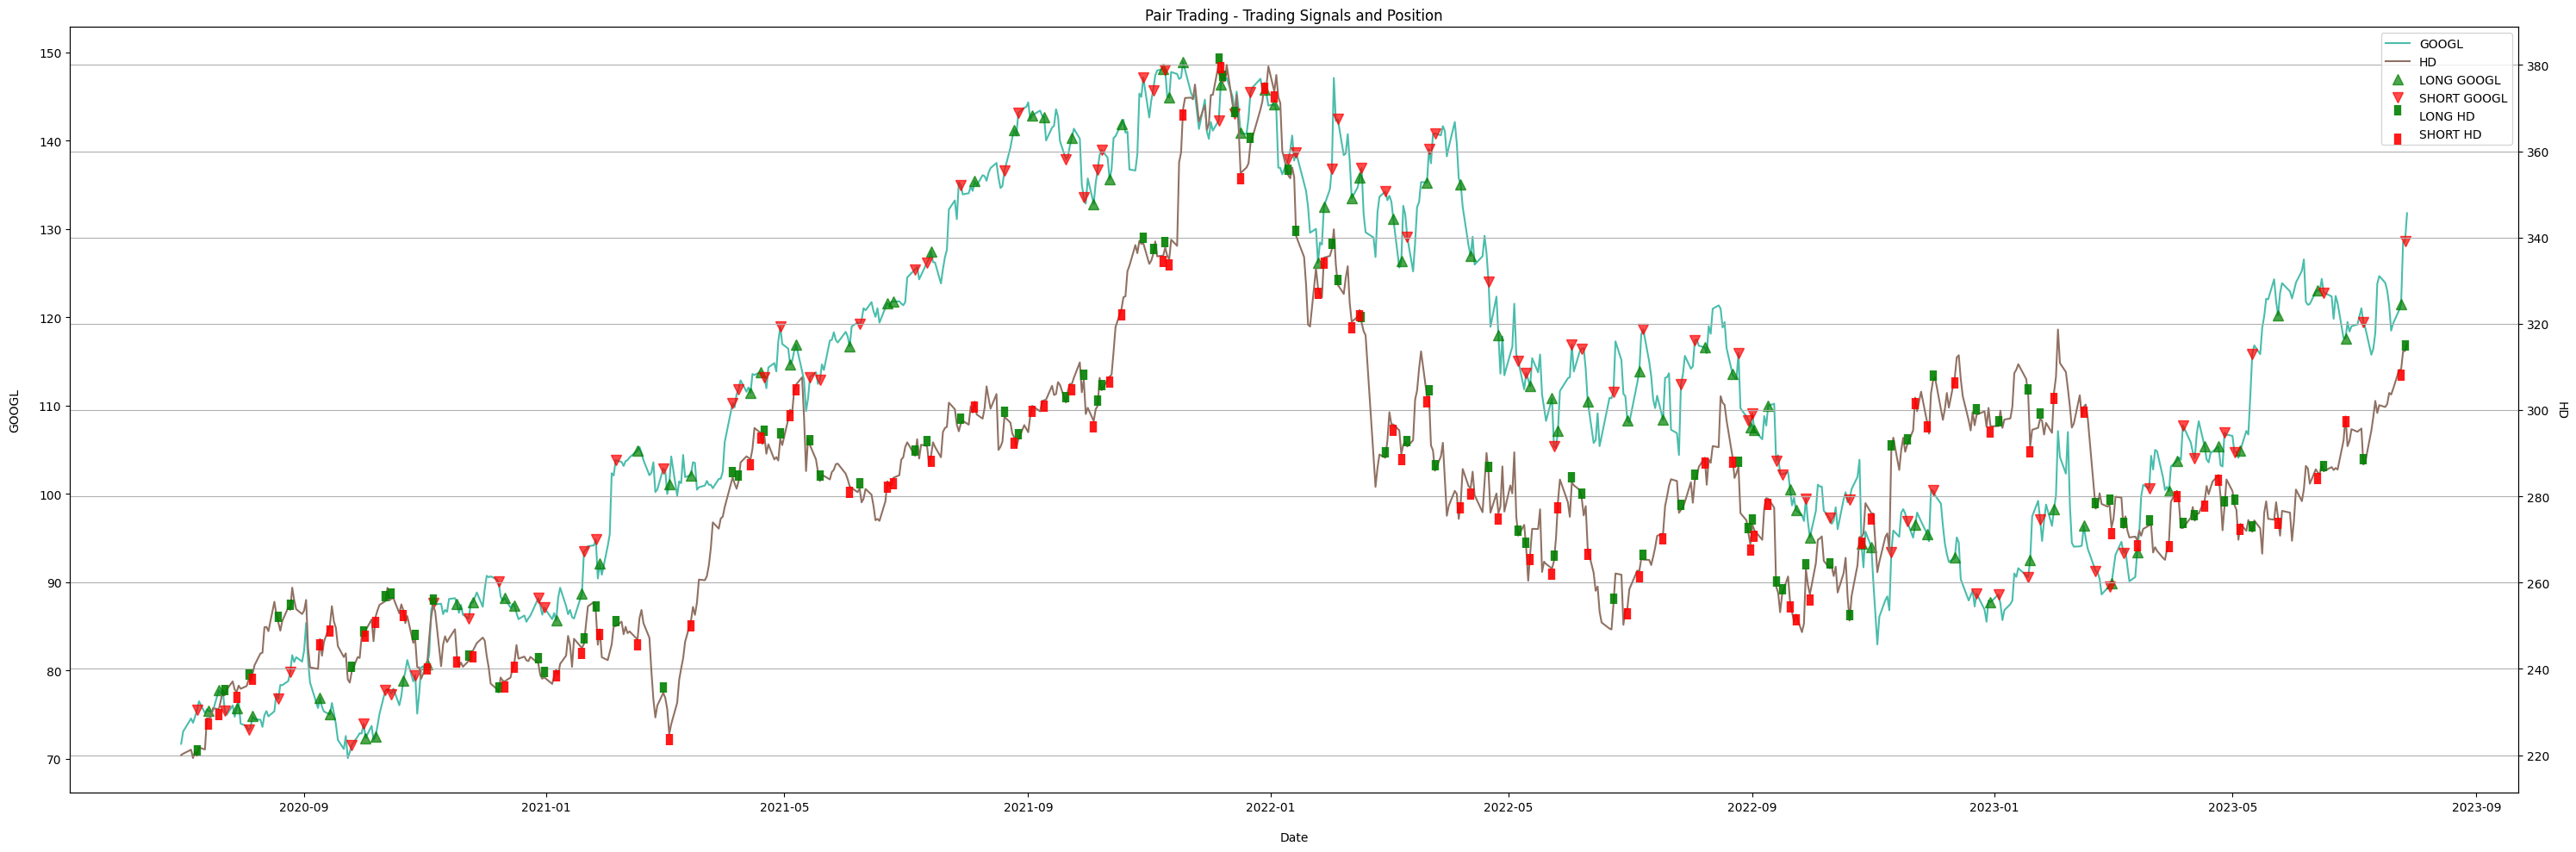

In [ ]:
fig=plt.figure(figsize=(30,10))
bx = fig.add_subplot(111)
bx2 = bx.twinx()
l1, = bx.plot(signals['asset1'], c='#4abdac')
l2, = bx2.plot(signals['asset2'], c='#907163')
u1, = bx.plot(signals['asset1'][signals['positions1'] == 1], lw=0, marker='^', markersize=8, c='g',alpha=0.7)
d1, = bx.plot(signals['asset1'][signals['positions1'] == -1], lw=0,marker='v',markersize=8, c='r',alpha=0.7)
u2, = bx2.plot(signals['asset2'][signals['positions2'] == 1], lw=0,marker=2,markersize=9, c='g',alpha=0.9, markeredgewidth=6)
d2, = bx2.plot(signals['asset2'][signals['positions2'] == -1], lw=0,marker=3,markersize=9, c='r',alpha=0.9,markeredgewidth=6)

bx.set_ylabel(asset1,)
bx2.set_ylabel(asset2, rotation=270)
bx.yaxis.labelpad=15
bx2.yaxis.labelpad=15
bx.set_xlabel('Date')
bx.xaxis.labelpad=15

plt.legend([l1,l2,u1,d1,u2,d2], [asset1, asset2,'LONG {}'.format(asset1),'SHORT {}'.format(asset1),'LONG {}'.format(asset2),'SHORT {}'.format(asset2)], loc ='best')

plt.title('Pair Trading - Trading Signals and Position')
plt.xlabel('Date')
plt.grid(True)
plt.tight_layout()

In [ ]:
initial_capital=100000
initial_capital2=initial_capital/(1+model.params[0])
initial_capital1=model.params[0]*initial_capital/(1+model.params[0])
positions1 = initial_capital1// max(signals['asset1'])
positions2 = initial_capital2// max(signals['asset2'])



In [ ]:
portfolio = pd.DataFrame()
portfolio['asset1'] = signals['asset1']
portfolio['holdings1'] = signals['positions1'].cumsum() * signals['asset1'] * positions1
portfolio['cash1'] = initial_capital1 - (signals['positions1'] * signals['asset1'] * positions1).cumsum()
portfolio['total asset1'] = portfolio['holdings1'] + portfolio['cash1']
portfolio['return1'] = portfolio['total asset1'].pct_change()
portfolio['positions1'] = signals['positions1']
portfolio['asset2'] = signals['asset2']
portfolio['holdings2'] = signals['positions2'].cumsum() * signals['asset2'] * positions2
portfolio['cash2'] = initial_capital2 - (signals['positions2'] * signals['asset2'] * positions2).cumsum()
portfolio['total asset2'] = portfolio['holdings2'] + portfolio['cash2']
portfolio['return2'] = portfolio['total asset2'].pct_change()
portfolio['positions2'] = signals['positions2']
portfolio['z'] = signals['z']
portfolio['total asset'] = portfolio['total asset1'] + portfolio['total asset2']
portfolio['return']=portfolio['total asset'].pct_change()
portfolio['z upper limit'] = signals['z upper limit']
portfolio['z lower limit'] = signals['z lower limit']
portfolio = portfolio.dropna()

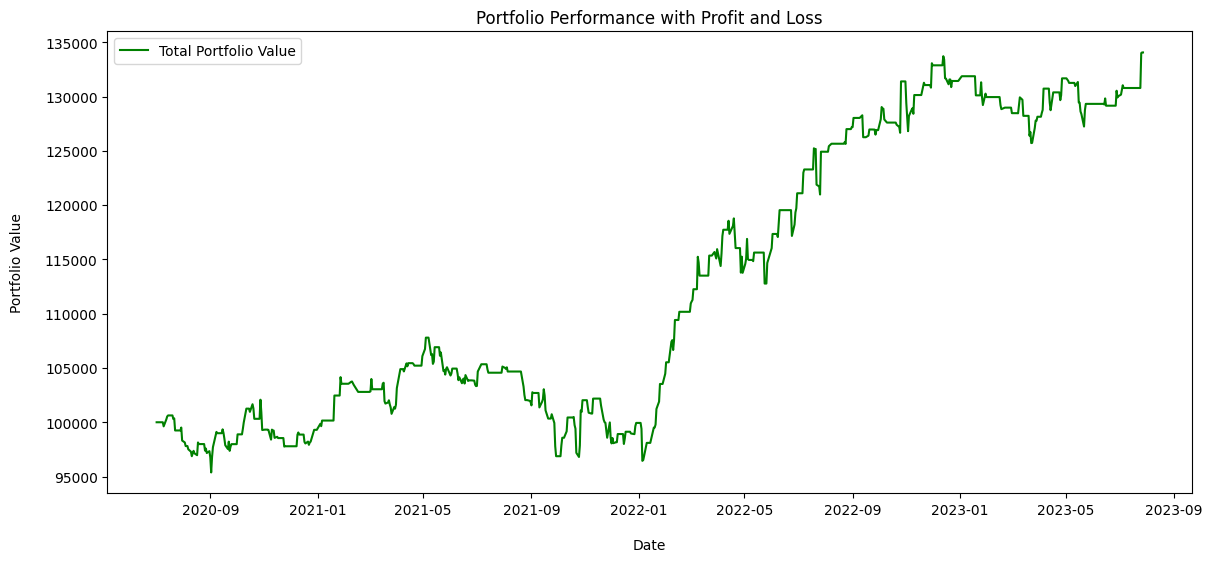

In [ ]:
fig = plt.figure(figsize=(14,6))
ax = fig.add_subplot(111)
l1, = ax.plot(portfolio['total asset'], c='g')
ax.set_ylabel('Portfolio Value')
ax.yaxis.labelpad=15
ax.set_xlabel('Date')
ax.xaxis.labelpad=15
plt.title('Portfolio Performance with Profit and Loss')
plt.legend([l1],['Total Portfolio Value'],loc='upper left');

In [ ]:
final_portfolio = portfolio['total asset'].iloc[-1]
delta = (portfolio.index[-1] - portfolio.index[0]).days
print('Number of days = ', delta)
YEAR_DAYS = 365
returns = (final_portfolio/initial_capital) ** (YEAR_DAYS/delta) - 1
print('CAGR = {:.3f}%' .format(returns * 100))
Maximum_Drawdown=(portfolio['total asset'].min()-portfolio['total asset'].max())/portfolio['total asset'].max()
print("Maximum_Drawdown is: ",Maximum_Drawdown)
print("Frequency is: ", signals['asset1'][signals['positions1'] == 1].count())

Number of days =  1121
CAGR = 10.014%
Maximum_Drawdown is:  -0.2885342326210977
Frequency is:  88
